In [175]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### zad1: kalibracja kamery

In [176]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW  # inner size of chessboard

width = 9
height = 6
square_size = 0.025 # 0.025 meters

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (8,6,0)
objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1,2)
objp = objp * square_size  # Create real world coords . Use your metric .

# Arrays to store object points and image points from all the images .
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane .
img_width = 640
img_height = 480
image_size = (img_width, img_height)

path = "materialy/"
image_dir = path + "pairs/"
number_of_images = 50

for i in range(1, number_of_images):
    # read image
    img = cv2.imread(image_dir + "left_%02d.png" % i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (width, height), 
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    Y, X, channels = img.shape
    
    # skip images where the corners of the chessboard are too close to the edges of the image
    if (ret == True):
        minRx = corners[:, :, 0].min()
        maxRx = corners[:, :, 0].max()
        minRy = corners[:, :, 1].min()
        maxRy = corners[:, :, 1].max()
        
        border_threshold_x = X/12
        border_threshold_y = Y/12
        
        x_thresh_bad = False

    if (minRx < border_threshold_x):
        x_thresh_bad = True
        y_thresh_bad = False
        if (minRy < border_threshold_y):
            y_thresh_bad = True
        
        if (y_thresh_bad == True) or (x_thresh_bad == True):
            continue
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        # improving the location of points (sub - pixel)
        corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        # Show the image to see if pattern is found ! imshow function .
        cv2.drawChessboardCorners(img, (width, height), corners2, ret)
        cv2.imshow("Corners", img)
        cv2.waitKey(5)
    else:
        print("Chessboard couldn't detected. Image pair: ", i)
        continue

cv2.destroyAllWindows()

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range (N_OK)]

ret, K, D, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        image_size,
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

# Let's rectify our results
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv2.CV_16SC2)


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

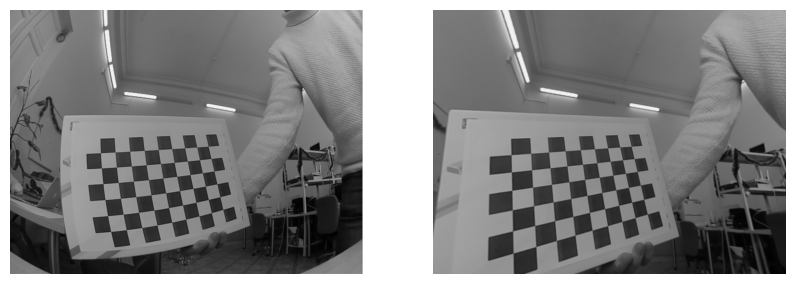

In [177]:
image = cv2.imread("materialy/pairs/left_15.png")
undistorted_image = cv2.remap(image, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image)
plt.axis('off')

plt.subplot(122)
plt.imshow(undistorted_image)
plt.axis('off')

In [178]:
for i in range(1, number_of_images):
    image_path = image_dir + "left_%02d.png" % i
    image = cv2.imread(image_path)

    if image is None:
        print(f"Nie można wczytać obrazu: {image_path}")
        continue

    undistorted_image = cv2.remap(
        image, map1, map2,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    # połączenie obrazów poziomo
    combined = np.hstack((image, undistorted_image))
    cv2.imshow("correction comparison", combined)

    key = cv2.waitKey(100)
    if key == 27: 
        break

cv2.destroyAllWindows()


### zad2: kalibracja układu kamer

In [179]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW  # inner size of chessboard

width = 9
height = 6
square_size = 0.025  # 0.025 meters

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (8,6,0)
objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)
objp = objp * square_size  # Create real world coords . Use your metric .

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpointsLeft = []  # 2d points in image plane (left)
imgpointsRight = []  # 2d points in image plane (right)
img_width = 640
img_height = 480
image_size = (img_width, img_height)

path = "materialy/"
image_dir = path + "pairs/"
number_of_images = 50

for i in range(1, number_of_images):
    # read left and right images
    img_left = cv2.imread(image_dir + "left_%02d.png" % i)
    img_right = cv2.imread(image_dir + "right_%02d.png" % i)

    gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    ret_left, corners_left = cv2.findChessboardCorners(gray_left, (width, height), 
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    ret_right, corners_right = cv2.findChessboardCorners(gray_right, (width, height), 
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    Y, X = gray_left.shape

    if ret_left and ret_right:
        minRx = corners_left[:, :, 0].min()
        minRy = corners_left[:, :, 1].min()
        border_threshold_x = X / 12
        border_threshold_y = Y / 12

        if minRx < border_threshold_x or minRy < border_threshold_y:
            continue

        corners_left_subpix = cv2.cornerSubPix(gray_left, corners_left, (3, 3), (-1, -1), criteria)
        corners_right_subpix = cv2.cornerSubPix(gray_right, corners_right, (3, 3), (-1, -1), criteria)

        objpoints.append(objp)
        imgpointsLeft.append(corners_left_subpix)
        imgpointsRight.append(corners_right_subpix)

        cv2.drawChessboardCorners(img_left, (width, height), corners_left_subpix, ret_left)
        cv2.drawChessboardCorners(img_right, (width, height), corners_right_subpix, ret_right)

        cv2.imshow("Corners - Left", img_left)
        cv2.imshow("Corners - Right", img_right)
        cv2.waitKey(5)

cv2.destroyAllWindows()

# K, D matrices for both cameras
K_left = np.zeros((3, 3))
D_left = np.zeros((4, 1))
K_right = np.zeros((3, 3))
D_right = np.zeros((4, 1))

# Calibrate individual cameras
N_OK = len(objpoints)
rvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
tvecs_left = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
rvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
tvecs_right = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]

cv2.fisheye.calibrate(objpoints, imgpointsLeft, image_size, K_left, D_left, 
                      rvecs_left, tvecs_left, calibration_flags, criteria)
cv2.fisheye.calibrate(objpoints, imgpointsRight, image_size, K_right, D_right, 
                      rvecs_right, tvecs_right, calibration_flags, criteria)

# stereo calibration, rectify and map generation
imgpointsLeft = np.asarray(imgpointsLeft, dtype=np.float64)
imgpointsRight = np.asarray(imgpointsRight, dtype=np.float64)

(RMS, _, _, _, _, rotationMatrix, translationVector) = cv2.fisheye.stereoCalibrate(
    objpoints, imgpointsLeft, imgpointsRight,
    K_left, D_left,
    K_right, D_right,
    image_size, None, None,
    cv2.CALIB_FIX_INTRINSIC,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
)

R2 = np.zeros([3, 3])
P1 = np.zeros([3, 4])
P2 = np.zeros([3, 4])
Q = np.zeros([4, 4])

(leftRectification, rightRectification, leftProjection, rightProjection,
 dispartityToDepthMap) = cv2.fisheye.stereoRectify(
    K_left, D_left,
    K_right, D_right,
    image_size,
    rotationMatrix, translationVector,
    0, R2, P1, P2, Q,
    cv2.CALIB_ZERO_DISPARITY, (0, 0), 0, 0
)

map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
    K_left, D_left, leftRectification,
    leftProjection, image_size, cv2.CV_16SC2
)
map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(
    K_right, D_right, rightRectification,
    rightProjection, image_size, cv2.CV_16SC2
)


In [180]:
img_l = cv2.imread(image_dir + "left_15.png")  
img_r = cv2.imread(image_dir + "right_15.png")  

# Mapowanie obrazu lewego i prawego przy użyciu funkcji remap
dst_L = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
dst_R = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)

# Sprawdzanie działania rektyfikacji poprzez zestawienie obu obrazów obok siebie
N, XX, YY = dst_L.shape[::-1]  # RGB image size
visRectify = np.zeros((YY, XX * 2, N), np.uint8)  # Nowe zdjęcie o podwójnej szerokości

visRectify[:, 0:XX, :] = dst_L  # Przydzielamy lewy obraz
visRectify[:, XX:XX * 2, :] = dst_R  # Przydzielamy prawy obraz

# Rysowanie poziomych linii co 10 pikseli
for y in range(0, YY, 10):
    cv2.line(visRectify, (0, y), (XX * 2, y), (0, 255, 0)) 

# Wyświetlanie rektyfikowanego obrazu
cv2.imshow('visRectify', visRectify)
cv2.waitKey(0)
cv2.destroyAllWindows()


### zad3: korespondencja stereo

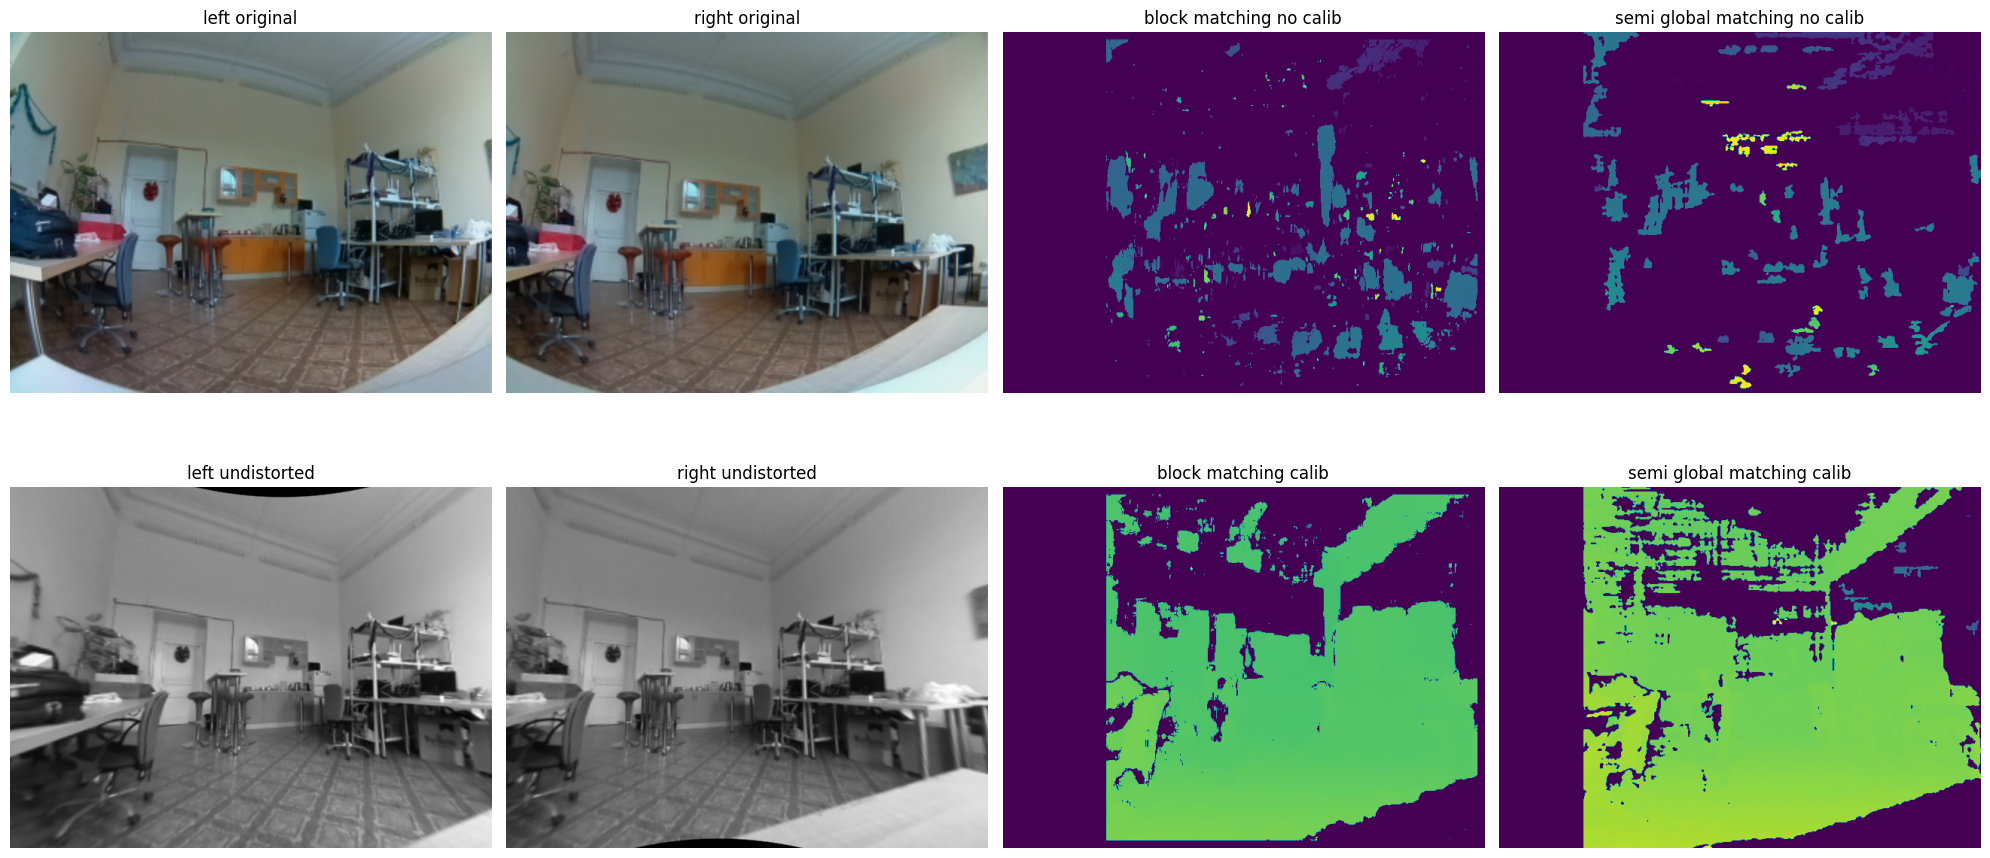

In [181]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

example_img = cv2.imread("materialy/example/example1.png")
h, w = example_img.shape[:2]

# podzial obrazu na lewy i prawy
img_left_orig = example_img[:, :w//2]
img_right_orig = example_img[:, w//2:]

# resize do mapy kalibracji
img_left_resized = cv2.resize(img_left_orig, (image_size))
img_right_resized = cv2.resize(img_right_orig, (image_size))

# rectification
img_left_rectified = cv2.remap(img_left_resized, map1_left, map2_left, interpolation=cv2.INTER_LINEAR)
img_right_rectified = cv2.remap(img_right_resized, map1_right, map2_right, interpolation=cv2.INTER_LINEAR)

gray_left_orig = cv2.cvtColor(img_left_resized, cv2.COLOR_BGR2GRAY)
gray_right_orig = cv2.cvtColor(img_right_resized, cv2.COLOR_BGR2GRAY)
gray_left_rect = cv2.cvtColor(img_left_rectified, cv2.COLOR_BGR2GRAY)
gray_right_rect = cv2.cvtColor(img_right_rectified, cv2.COLOR_BGR2GRAY)

stereo_bm = cv2.StereoBM_create(numDisparities=128, blockSize=21)

stereo_sgm = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=112,       # Musi być podzielne przez 16
    blockSize=5,              # Rozmiar bloku dopasowania (im większy, tym gładsze wyniki)

    P1=8 * 1 * 5 ** 2,        # Kara za niewielką zmianę dysparycji
    P2=32 * 1 * 5 ** 2,       # Kara za dużą zmianę dysparycji (musi być > P1)

    disp12MaxDiff=1,          # Różnica między dopasowaniem lewo->prawo a prawo->lewo
    preFilterCap=31,          # Ograniczenie wartości pikseli (typowo 31)
    uniquenessRatio=40,       # Wymagany % przewagi najlepszego dopasowania nad drugim (większa wartość = mniej błędów)
    
    speckleWindowSize=100,    # Wielkość okna dla usuwania szumu (plam)
    speckleRange=32,          # Zakres różnicy dysparycji dla "plam"

    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY 
)


# dysparycje przed kalibracją
disp_bm_before = stereo_bm.compute(gray_left_orig, gray_right_orig).astype(np.float32) 
disp_sgm_before = stereo_sgm.compute(gray_left_orig, gray_right_orig).astype(np.float32) 

# dysparycje po kalibracji
disp_bm_after = stereo_bm.compute(gray_left_rect, gray_right_rect).astype(np.float32) 
disp_sgm_after = stereo_sgm.compute(gray_left_rect, gray_right_rect).astype(np.float32)

# normalizacja do wizualizacji
def normalize_disparity(disp):
    disp_norm = cv2.normalize(disp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return disp_norm

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0, 0].imshow(cv2.cvtColor(img_left_resized, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title("left original")
axs[0, 1].imshow(cv2.cvtColor(img_right_resized, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title("right original")
axs[0, 2].imshow(normalize_disparity(disp_bm_before))
axs[0, 2].set_title("block matching no calib")
axs[0, 3].imshow(normalize_disparity(disp_sgm_before))
axs[0, 3].set_title("semi global matching no calib")

axs[1, 0].imshow(gray_left_rect, cmap='gray')
axs[1, 0].set_title("left undistorted")
axs[1, 1].imshow(gray_right_rect, cmap='gray')
axs[1, 1].set_title("right undistorted")
axs[1, 2].imshow(normalize_disparity(disp_bm_after))
axs[1, 2].set_title("block matching calib")
axs[1, 3].imshow(normalize_disparity(disp_sgm_after))
axs[1, 3].set_title("semi global matching calib")

for ax in axs.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()
